In [117]:
import Pkg

using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
using CSV
using Random
using DataFrames
using Optimisers
using Statistics
using Plots

using DecisionTree


In [172]:
sunspot_data = CSV.read("Sunspot_data.csv", DataFrame)

sunspots = sunspot_data[:, 3];

In [170]:
function create_sequences(data, seq_len)
    X, y = [], []
    for i in 1:(length(data) - seq_len)
        push!(X, data[i:i+seq_len-1])
        push!(y, data[i+seq_len])
    end
    return hcat(X...), y  # Convert to matrix form
end

seq_len = 50  # Lookback window
X, y = create_sequences(sunspots, seq_len)

# Normalize
X = (X .- mean(X)) ./ std(X)
y = (y .- mean(y)) ./ std(y)

train_ratio = 0.9


split_var = Int(train_ratio * size(X, 2))

X_train, y_train = X[:, 1:split_var], y[1:split_var]
X_test, y_test = X[:, split_var+1:end], y[split_var+1:end]

X_train = reshape(X_train, size(X_train, 1), 1, size(X_train, 2))
X_test = reshape(X_test, size(X_test, 1), 1, size(X_test, 2))

y_train = reshape(y_train, 1, length(y_train))  # Convert to (1, batch_size)
y_test = reshape(y_test, 1, length(y_test))    # Convert to (1, batch_size)
;

LoadError: MethodError: no method matching /(::String7, ::Int64)
The function `/` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  /([91m::BigFloat[39m, ::Union{Int16, Int32, Int64, Int8})
[0m[90m   @[39m [90mBase[39m [90m[4mmpfr.jl:553[24m[39m
[0m  /([91m::Missing[39m, ::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:123[24m[39m
[0m  /([91m::BigInt[39m, ::Union{Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8})
[0m[90m   @[39m [90mBase[39m [90m[4mgmp.jl:560[24m[39m
[0m  ...


In [ ]:
X_train

50×1×2493 Array{Float64, 3}:
[:, :, 1] =
  0.17106467395833486
  0.2773752255219594
  0.4483965476025728
  0.11790939817652266
  0.7950613896578702
  0.7603949054523406
  1.0215490864673311
  0.36288588656226606
  0.5847513854776566
  0.5755069896895152
  2.4960302146758626
  0.7996835875519409
  0.5246628128547381
  ⋮
  0.471507537072926
  0.2011089602697939
  0.21035335605793531
 -0.2541775322961633
  0.6425288591535395
 -0.4922207238408009
 -0.5430649006755778
 -0.09240060600369115
 -0.3003995112368696
 -0.24493313650802206
 -0.1524891786266094
 -0.4298210522708474

[:, :, 2] =
  0.2773752255219594
  0.4483965476025728
  0.11790939817652266
  0.7950613896578702
  0.7603949054523406
  1.0215490864673311
  0.36288588656226606
  0.5847513854776566
  0.5755069896895152
  2.4960302146758626
  0.7996835875519409
  0.5246628128547381
  0.5847513854776566
  ⋮
  0.2011089602697939
  0.21035335605793531
 -0.2541775322961633
  0.6425288591535395
 -0.4922207238408009
 -0.5430649006755778
 -0.09

In [ ]:
model = Chain(
    Conv((5,), 1=>16, relu),
    MaxPool((2,)),
    BatchNorm(16),
    Conv((3,), 16=>32, relu),
    MaxPool((2,)),
    BatchNorm(32),
    Flux.flatten,
    Dense(320, 64, relu),  
    Dense(64, 10, relu),
    Dense(10, 1),
     )    # Output a single prediction)


Chain(
  Conv((5,), 1 => 16, relu),            # 96 parameters
  MaxPool((2,)),
  BatchNorm(16),                        # 32 parameters, plus 32
  Conv((3,), 16 => 32, relu),           # 1_568 parameters
  MaxPool((2,)),
  BatchNorm(32),                        # 64 parameters, plus 64
  Flux.flatten,
  Dense(320 => 64, relu),               # 20_544 parameters
  Dense(64 => 10, relu),                # 650 parameters
  Dense(10 => 1),                       # 11 parameters
)         # Total: 14 trainable arrays, 22_965 parameters,
          # plus 4 non-trainable, 96 parameters, summarysize 91.184 KiB.

In [ ]:
epochs = 200
batch_size = 64;

In [ ]:
opt = ADAM()

data_loader = Flux.DataLoader((X_train, y_train), batchsize=batch_size, shuffle=true)

# Initialize optimizer state
opt_state = Flux.setup(opt, model)  

total_loss = []

for epoch in 1:epochs
    epoch_loss = 0
    for (x, y) in data_loader
        gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
        Flux.update!(opt_state, Flux.trainable(model), gs)
        epoch_loss += Flux.Losses.mse(model(x), y)
    end
    println("Epoch $epoch - Train Loss: $epoch_loss")
    push!(total_loss, epoch_loss)
end


Epoch 1 - Train Loss: 23.009166068147376
Epoch 2 - Train Loss: 7.57983536898096
Epoch 3 - Train Loss: 6.2334012619191865
Epoch 4 - Train Loss: 5.740655828597761
Epoch 5 - Train Loss: 4.99086091298876
Epoch 6 - Train Loss: 4.563785263492788
Epoch 7 - Train Loss: 4.13039878184337
Epoch 8 - Train Loss: 4.022783467773583
Epoch 9 - Train Loss: 3.9178779411013456
Epoch 10 - Train Loss: 3.603412521183976
Epoch 11 - Train Loss: 3.3277457399715575
Epoch 12 - Train Loss: 3.1586117680622547
Epoch 13 - Train Loss: 3.064561670430927
Epoch 14 - Train Loss: 2.6429337323703974
Epoch 15 - Train Loss: 2.4651253216770965
Epoch 16 - Train Loss: 2.3687664827286525
Epoch 17 - Train Loss: 2.441646602025795
Epoch 18 - Train Loss: 2.0535483610368788
Epoch 19 - Train Loss: 2.119912354744971
Epoch 20 - Train Loss: 2.044256322048589
Epoch 21 - Train Loss: 1.9255440282738276
Epoch 22 - Train Loss: 1.8264372343549569
Epoch 23 - Train Loss: 1.6722469075500688
Epoch 24 - Train Loss: 1.617630681906017
Epoch 25 - Train

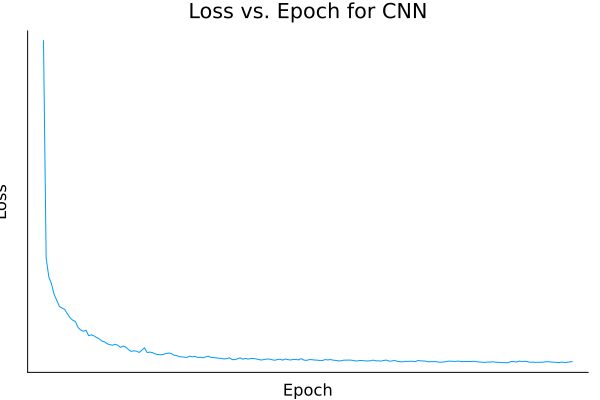

In [ ]:
p1 = plot(1:epochs, total_loss, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch for CNN", legend=false, xticks=false, yticks=false)
display(p1)

In [ ]:
model_forest = RandomForestRegressor(n_trees=3000, max_depth=10)

X_train_forest = reshape(X_train, size(X_train, 3), size(X_train, 1)) 
X_test_forest = reshape(X_test, size(X_test, 3), size(X_test, 1))
y_train_forest = vec(y_train)
y_test_forest = vec(y_test)

DecisionTree.fit!(model_forest, X_train_forest, y_train_forest)

RandomForestRegressor
n_trees:             3000
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           10
min_samples_leaf:    5
min_samples_split:   2
min_purity_increase: 0.0
ensemble:            Ensemble of Decision Trees
Trees:      3000
Avg Leaves: 105.42933333333333
Avg Depth:  10.0

In [ ]:
preds_CNN = model(X_test)


1×277 Matrix{Float32}:
 0.133623  0.133623  0.190918  0.295783  …  1.05366  0.582353  0.658716

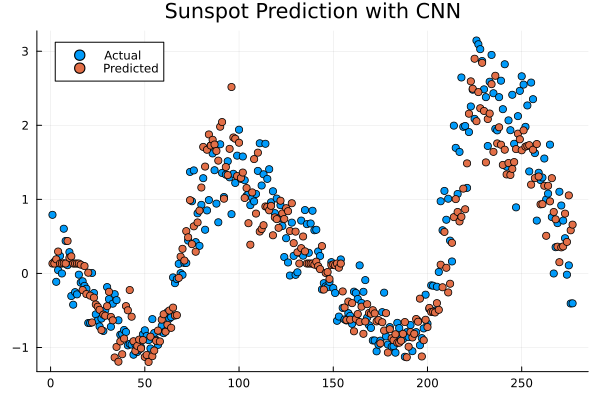

In [ ]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction with CNN")
scatter!(1:length(preds_CNN[1, :]), preds_CNN[1, :], label="Predicted")

In [ ]:
preds_forest = DecisionTree.predict(model_forest, X_test_forest);

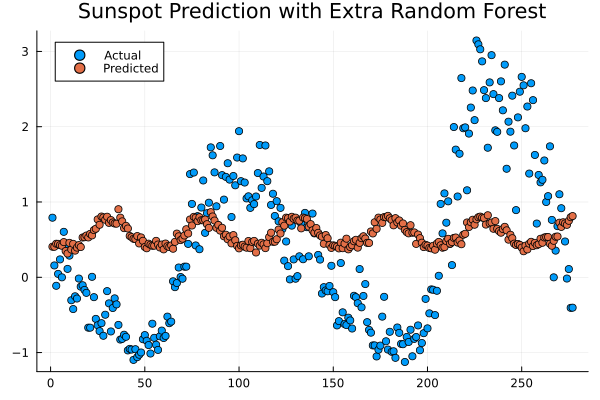

In [ ]:
scatter(1:length(y_test_forest), y_test_forest, label="Actual", title="Sunspot Prediction with Extra Random Forest")
scatter!(1:length(preds_forest), preds_forest, label="Predicted")